# Code Overview


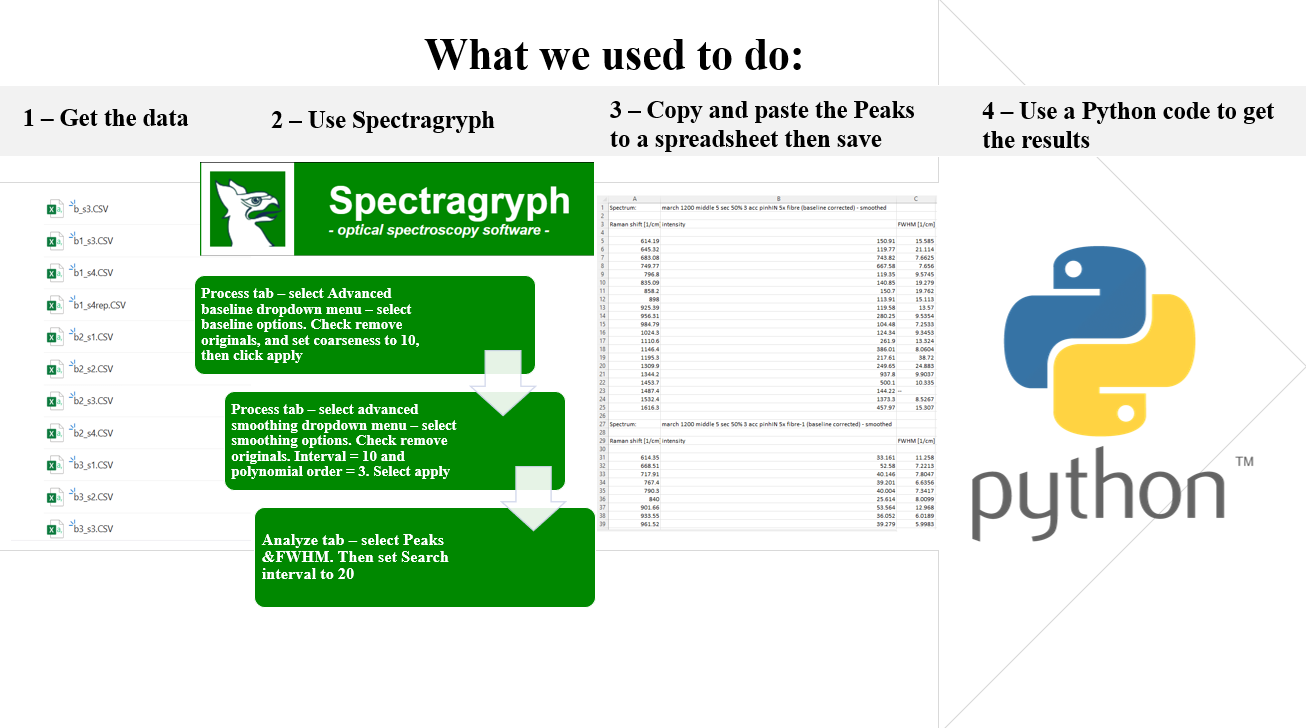
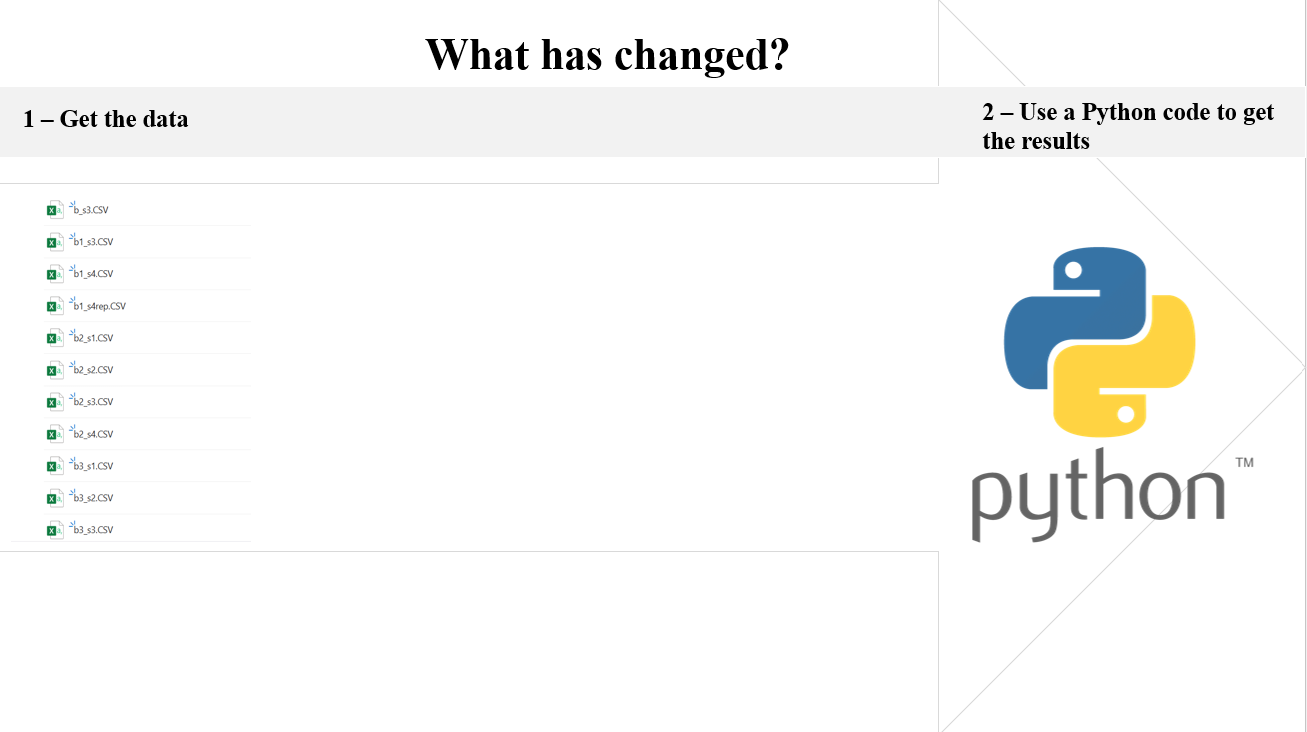

The new Python code provides a comprehensive set of functionalities for Raman spectroscopy data analysis:

## 1. Baseline Removal
The user has the flexibility to choose from four baseline removal methods:

a. **Asymmetric Least Squares (ALS)**
   - Developed by P. Eilers and H. Boelens (2005).
   - Source: [StackOverflow - Python Baseline Correction Library]

b. **BaselineRemoval Package**
   - Developed by Md Azimul Haque (2022).
   - Implements three methods:
     - **Modpoly:** Modified multi-polynomial fit by Lieber & Mahadevan-Jansen (2003).
     - **IModPoly:** Improved ModPoly by Zhao (2007).
     - **ZhangFit:** Adaptive iteratively reweighted penalized least squares by Zhi-Min Zhang (2010).
   - Source: [PyPI – BaselineRemoval]

## 2. Smoothing
The code offers smoothing using the Savitzky-Golay filter, commonly used for noisy data. Users can specify:
   - The length of the smoothing window.
   - The order of the polynomial used for fitting the data within the window.
   - Implementation available in the SciPy library.
   - Source: [SciPy - savgol_filter]

## 3. Peak Picking
The code includes a peak-picking algorithm to identify local maxima in the signal. Users can customize:
   - The minimum peak height.
   - The minimum horizontal peak spacing.
   - The minimum peak width.
   - Implementation available in the SciPy library.
   - Source: [SciPy - find_peaks]

## 4. Plotting (Optional)
The code provides an optional plotting feature for data visualization.

## 5. Determine the Type of an Unknown Polymer
The code enables users to determine the type of an unknown polymer by comparing the Raman shift values. Users can specify:
   - The absolute difference between the peaks of the unknown polymer and the values in a polymer library.
   - The percentage of closeness or similarity, which can be highlighted based on this difference.

This Python code offers a versatile toolbox for Raman spectroscopy data analysis, with various customization options for baseline removal, smoothing, peak picking, and polymer identification.

---

# **! Important !**
### **Before running the code, make sure to have the following Python libraries installed:**
---
- [`numpy`](https://pypi.org/project/numpy/): Import as `np`. Usually installed with `pip install numpy`.
- [`pandas`](https://pypi.org/project/pandas/): Import as `pd`. Usually installed with `pip install pandas`.
- [`matplotlib`](https://pypi.org/project/matplotlib/): Specifically, `matplotlib.pyplot`, import as `plt`. Usually installed with `pip install matplotlib`.
- [`scipy`](https://pypi.org/project/scipy/): Includes `sparse`, `sparse.linalg` (as `spsolve`), and `signal` (as `savgol_filter`, `find_peaks`). Usually installed with `pip install scipy`.
- [`ipywidgets`](https://pypi.org/project/ipywidgets/): Import as `widgets`. Usually installed with `pip install ipywidgets`.
- [`IPython`](https://pypi.org/project/ipython/): Specifically, `IPython.display`, import as `display`. Usually installed with `pip install ipython`.
- [`BaselineRemoval`](https://pypi.org/project/BaselineRemoval/): For baseline removal algorithms. Usually installed with `pip install BaselineRemoval`.
- [`openpyxl`](https://pypi.org/project/openpyxl/): Import as `Workbook`, `NamedStyle`, and use `utils.dataframe` (as `dataframe_to_rows`). Usually installed with `pip install openpyxl`.
- [`xlsxwriter`](https://pypi.org/project/XlsxWriter/): For writing files in the XLSX file format. Usually installed with `pip install XlsxWriter`.

---

## Additional Support

For more details or if you encounter any issues, please don't hesitate to contact Fuad Alqrianwi (f.y.m.alqrinawi@bham.ac.uk.com) for further assistance.


---
## Notebook Overview
This notebook includes the following sections:
- **S1: Visualizing the Background Removal, Smoothing, and Peak Picking**
- **1.0 Load Your Data and Choose the Parameters.**
- **S2: Process Multiple Files and Get the Unknown Polymer Type**
- **2.0 Load Your Data and Choose the Parameters.**
- **S3: Matching Unknown Polymers to the Known Library.**
- **3.0 Loading Data and Configuring Parameters for Polymer Comparison.**

---

### Navigation Tips:
- **S1, S2, and S2** are the source code sections. If you're primarily interested in the outcomes and implementation; just excute the code without changing anything.
---


## S1: Visualizing the background removal, smoothing, and peak picking (One file at a time)

*Note: This section includes source code integral to the process. If you are not focused on understanding the technical specifics, there is no need to modify any settings. Simply execute the code and proceed*

---

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, find_peaks
import ipywidgets as widgets
from IPython.display import display
from BaselineRemoval import BaselineRemoval  # Assuming you have a baseline removal library

# Function to estimate baseline using ALS
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function to process and plot the data for all methods
def process_and_plot(method, poly_degree, iters, conv_thresh, lambda_zhang, porder, repitition, lam_als, p_als,
                     window_length, poly_order,
                     peak_prominence, peak_distance, peak_width):
    plt.figure(figsize=(20,12))
    #plt.plot(data['Wave'], data['Intensity'], label='Original Data', color='grey')

    if method == 'ALS':
        baseline = data['Intensity'].values-baseline_als(data['Intensity'].values, lam_als, p_als)
        # For ALS, plot only the estimated baseline
        #plt.plot(data['Wave'], baseline, 'r--', label='Estimated Baseline (ALS)', linewidth=2)
    else:
        baseObj = BaselineRemoval(data['Intensity'].values)
        if method == 'ModPoly':
            baseline = baseObj.ModPoly(poly_degree, iters, conv_thresh)
        elif method == 'IModPoly':
            baseline = baseObj.IModPoly(poly_degree, iters, conv_thresh)
        elif method == 'ZhangFit':
            baseline = baseObj.ZhangFit(lambda_=lambda_zhang, porder=porder, repitition=repitition)
            
        
    
    smoothed_output = savgol_filter(baseline, window_length, poly_order)

    # Peak finding
    peaks, properties = find_peaks(
        smoothed_output, 
        prominence=peak_prominence, 
        distance=peak_distance, 
        width=peak_width
    )

    # Collecting Peak Values
    
    peak_wavelengths = data['Wave'].iloc[peaks].values
    peak_intensities = smoothed_output[peaks]

    # Create a Pandas DataFrame for the peak data
    peak_data = {
        'Raman shift [1/cm]': peak_wavelengths,
        'intensity': peak_intensities
    }
    peak_df = pd.DataFrame(peak_data)
    
    
    corrected_intensity = data['Intensity'].values - baseline
    
    half_line = '-' * 40
    stars = '*' * 40
    print(stars)
    print("These graphs are based on these values:")
    print(stars)
    print(f"method: {method}")
    print(half_line)
    print("Parameters for ModPoly and IModPoly:")
    print(f"poly_degree: {poly_degree}")
    print(f"iters: {iters}")
    print(f"conv_thresh: {conv_thresh}")
    print(half_line)
    print("Parameters for Zhang Method:")
    print(f"lambda_zhang: {lambda_zhang}")
    print(f"porder: {porder}")
    print(f"repitition: {repitition}")
    print(half_line)
    print("Parameters for ALS Method:")
    print(f"lam_als: {lam_als}")
    print(f"p_als: {p_als}")
    print(half_line)
    print("Parameters for Smoothing:")
    print(f"window_length: {window_length}")
    print(f"poly_order: {poly_order}")
    print(half_line)
    print("Parameters for Peak Picking:")
    print(half_line)
    print(f"peak_prominence: {peak_prominence}")
    print(f"peak_distance: {peak_distance}")
    print(f"peak_width: {peak_width}")
    print(stars)
    
        # For other methods, plot both the estimated baseline and corrected intensity
    plt.figure(figsize=(12, 12))

    # Plot the first set of data
    plt.subplot(2, 1, 1)
    plt.plot(data['Wave'], data['Intensity'], label='Original Data', color='grey')
    plt.plot(data['Wave'], corrected_intensity, 'g--', label='Baseline')
    plt.plot(data['Wave'], baseline, color='blue', label='Original Data - Baseline', linewidth=1)
    #plt.plot(data['Wave'], smoothed_output, 'b--', label='Smoothed Data', linewidth=2)
    #plt.plot(peak_wavelengths, peak_intensities, "x", color='red', label='Peaks', markersize=10, linewidth=10)

    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.xlabel('Raman Shift', fontsize=20)
    plt.ylabel('Intensity', fontsize=20)
    plt.title(f'Spectrum Analysis using {method} Method', fontsize=20)

    # Plot the second set of data beneath the first one
    plt.subplot(2, 1, 2)
    plt.plot(data['Wave'], smoothed_output, 'b--', label='Smoothed Data', linewidth=2)
    plt.plot(peak_wavelengths, peak_intensities, "x", color='red', label='Peaks', markersize=10, linewidth=10)

    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Raman Shift', fontsize=20)
    plt.ylabel('Intensity', fontsize=20)

    plt.tight_layout()
    plt.show()

---
## 1.0 Load Your Data and Choose the Parameters for Visualization (One file at a time)

*Note: This section is where you input the data for visualization and configure the parameters.*

**Input Parameters:**

1. **Parameters for ModPoly and IModPoly:**
    - `poly_degree`: Degree of the polynomial used for modeling.
    - `iters`: Number of iterations for optimization.
    - `conv_thresh`: Convergence threshold for optimization.



2. **Parameters for Zhang Method:**
    - `lambda_zhang`: Lambda parameter for the Zhang method.
    - `porder`: Order of the polynomial in the Zhang method.
    - `repitition`: Number of repetitions for the Zhang method.



3. **Parameters for ALS Method:**
    - `lam_als`: Lambda parameter for the ALS method.
    - `p_als`: P parameter for the ALS method.



4. **Parameters for Smoothing:**
    - `window_length`: Length of the smoothing window.
    - `poly_order`: Order of the polynomial for smoothing.



5. **Parameters for Peak Picking:**
    - `peak_prominence`: Prominence threshold for peak picking.
    - `peak_distance`: Minimum distance between peaks.
    - `peak_width`: Width parameter for peak picking.



*Note: All the parameters need to be provided. This is where you input the data for visualization.*

---

****************************************
These graphs are based on these values:
****************************************
method: ZhangFit
----------------------------------------
Parameters for ModPoly and IModPoly:
poly_degree: 3
iters: 100
conv_thresh: 0.01
----------------------------------------
Parameters for Zhang Method:
lambda_zhang: 50
porder: 10
repitition: 100
----------------------------------------
Parameters for ALS Method:
lam_als: 1000
p_als: 0.005
----------------------------------------
Parameters for Smoothing:
window_length: 20
poly_order: 3
----------------------------------------
Parameters for Peak Picking:
----------------------------------------
peak_prominence: 5
peak_distance: 20
peak_width: 3
****************************************


<Figure size 1440x864 with 0 Axes>

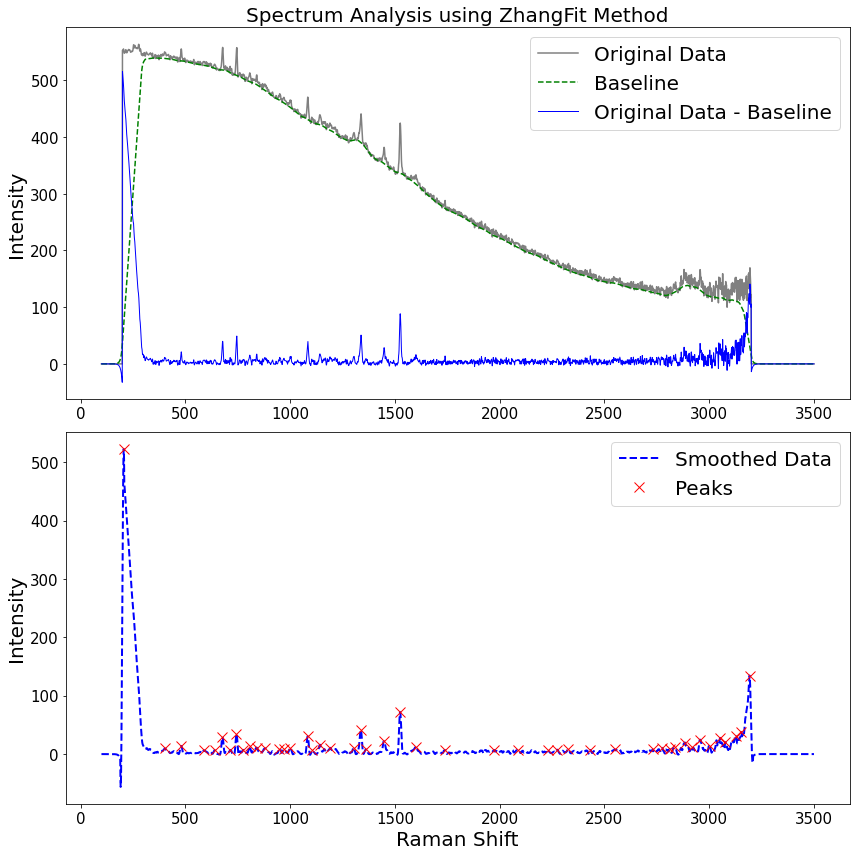

<Figure size 432x288 with 0 Axes>

In [21]:
# Load your data here

input_data = r"..\Data Directory\DataFile.CSV"
data = pd.read_csv(input_data, names=['Wave', 'Intensity'])

# Display the plot

process_and_plot(
    method='ZhangFit',
    poly_degree=3,
    iters=100,
    conv_thresh=0.01,
    lambda_zhang=50,
    porder=10,
    repitition=100,
    lam_als=1000,
    p_als=0.005,
    window_length=20,
    poly_order=3,
    peak_prominence=5,
    peak_distance=20,
    peak_width=3
)


plt.savefig('Spectra.png', bbox_inches='tight', dpi=100)

*Note: If you are happy with the background removal, smoothing, and peak picking from the above sction, you can proceed to the next section.*

---
## S2: Process Multiple Files

In this section, we present the source code necessary for processing multiple files and generating a single Excel file, which includes each file's name alongside the Raman shift values for the peaks, based on the parameters outlined in Section 1.0.

*Note: This section includes source code integral to the process. If you are not focused on understanding the technical specifics, there is no need to modify any settings. Simply execute the code and proceed*

---

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, find_peaks
import ipywidgets as widgets
from IPython.display import display
from BaselineRemoval import BaselineRemoval  
import os
from openpyxl import Workbook
from openpyxl.styles import Alignment, NamedStyle
from openpyxl.utils.dataframe import dataframe_to_rows


# Function to estimate baseline using ALS
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function to process and plot the data for all methods
def process_and_plot(file_path,method, poly_degree, iters, conv_thresh, lambda_zhang, porder, repitition, lam_als, p_als,
                     window_length, poly_order,
                     peak_prominence, peak_distance, peak_width, ws):
    
    try:
        # Reading the data
        data = pd.read_csv(file_path, names=['Wave', 'Intensity'], comment='#')
        print(f"Data from {file_path}:")  # Debugging print statement
        print(data.head())  # Print the first few rows of the data
        #plt.plot(data['Wave'], data['Intensity'], label='Original Data', color='grey')

        if method == 'ALS':
            baseline = data['Intensity'].values-baseline_als(data['Intensity'].values, lam_als, p_als)
            # For ALS, plot only the estimated baseline
            #plt.plot(data['Wave'], baseline, 'r--', label='Estimated Baseline (ALS)', linewidth=2)
        else:
            baseObj = BaselineRemoval(data['Intensity'].values)
            if method == 'ModPoly':
                baseline = baseObj.ModPoly(poly_degree, iters, conv_thresh)
            elif method == 'IModPoly':
                baseline = baseObj.IModPoly(poly_degree, iters, conv_thresh)
            elif method == 'ZhangFit':
                baseline = baseObj.ZhangFit(lambda_=lambda_zhang, porder=porder, repitition=repitition)

            # Smoothing
            smoothed_output = savgol_filter(baseline, window_length, poly_order)

            # Peak finding
            peaks, properties = find_peaks(
                smoothed_output, 
                prominence=peak_prominence, 
                distance=peak_distance, 
                width=peak_width
            )

            # Collecting Peak Values
            peak_wavelengths = data['Wave'].iloc[peaks].values
            peak_intensities = smoothed_output[peaks]

            # Create a Pandas DataFrame for the peak data
            peak_data = {
                'Raman shift [1/cm]': peak_wavelengths,
                'Intensity': peak_intensities
            }
            peak_df = pd.DataFrame(peak_data)

            # Sort peak data by Raman shift (ascending)
            peak_df.sort_values(by='Raman shift [1/cm]', ascending=True, inplace=True)

            # Create a named style for numeric formatting
            numeric_style = NamedStyle(name='numeric')
            numeric_style.number_format = '0.00'

            # Write headers with alignment
            ws.append(['Spectrum:', os.path.splitext(os.path.basename(file_path))[0]])
            ws.append(['', ''])
            ws.append(['', ''])
            ws.append(['Raman shift [1/cm]', 'Intensity'])

            # Write peak data with formatting, skipping the header
            for row in dataframe_to_rows(peak_df, index=False, header=False):
                ws.append([round(row[0], 2), round(row[1], 2)])
            ws.append(['', ''])
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

def process_files_in_folder(folder_path, output_excel_file, method, poly_degree, iters, conv_thresh, lambda_zhang, porder, repitition, lam_als, p_als,
                            window_length, poly_order, peak_prominence, peak_distance, peak_width):
    # Create a new Excel workbook
    wb = Workbook()
    ws = wb.active

    print(f"Checking all files in {folder_path}")  # Debugging print statement
    files_processed = 0  # Counter for files processed
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")  # Debugging print statement
            try:
                # Call process_and_plot function for each file with 'ws' parameter
                process_and_plot(file_path=file_path,
                                 method=method,
                                 poly_degree=poly_degree,
                                 iters=iters,
                                 conv_thresh=conv_thresh,
                                 lambda_zhang=lambda_zhang,
                                 porder=porder,
                                 repitition=repitition,
                                 lam_als=lam_als,
                                 p_als=p_als,
                                 window_length=window_length,
                                 poly_order=poly_order,
                                 peak_prominence=peak_prominence,
                                 peak_distance=peak_distance,
                                 peak_width=peak_width,
                                 ws=ws)
                files_processed += 1
            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

    # Create a named style for numeric formatting
    numeric_style = NamedStyle(name='numeric')
    numeric_style.number_format = '0.00'
    # Apply the numeric style to the cells in the data section
    for row in ws.iter_rows(min_row=3, min_col=2, max_col=2):
        for cell in row:
            cell.style = numeric_style

    # Save the Excel file
    wb.save(output_excel_file)
    print(f"Peak data saved to {output_excel_file}")

---

## 2.0 Load Your Data and Choose the Parameters for the Background Removal, Smoothing, and peak Picking.

In this section, you need to input the folder containing all the Excel files that have the unknown polymer Raman shift and intensity data to be processed together. You should also specify the location of the Excel file for the output.

- **`input_folder`**: Replace with the actual path to the folder containing the Excel files.
- **`output_excel_file`**: Specify the name where the processed data will be saved.

This output file will contain the values for the peaks Raman shift, based on the parameters mentioned in section 1.0.

---


In [23]:
input_folder = r"..\Data Directory\DataFile"  # Replace with your actual input folder path
output_excel_file = r"..\Your Output Directory\Processed_Peak_Data.xlsx"  # Specify the output Excel file name

process_files_in_folder(
    folder_path=input_folder,
    output_excel_file=output_excel_file,
    method='ZhangFit',
    poly_degree=3,
    iters=100,
    conv_thresh=0.01,
    lambda_zhang=50,
    porder=10,
    repitition=100,
    lam_als=1000,
    p_als=0.005,
    window_length=20,
    poly_order=3,
    peak_prominence=5,
    peak_distance=20,
    peak_width=3
)


Checking all files in D:\Raman\Final\csv_rubbish_recycling
Processing file: D:\Raman\Final\csv_rubbish_recycling\b1_s3.CSV
Data from D:\Raman\Final\csv_rubbish_recycling\b1_s3.CSV:
        Wave  Intensity
0   99.63733        0.0
1  100.60160        0.0
2  101.56580        0.0
3  102.53000        0.0
4  103.49430        0.0
Processing file: D:\Raman\Final\csv_rubbish_recycling\b1_s4.CSV
Data from D:\Raman\Final\csv_rubbish_recycling\b1_s4.CSV:
        Wave  Intensity
0   99.63733        0.0
1  100.60160        0.0
2  101.56580        0.0
3  102.53000        0.0
4  103.49430        0.0
Processing file: D:\Raman\Final\csv_rubbish_recycling\b1_s4rep.CSV
Data from D:\Raman\Final\csv_rubbish_recycling\b1_s4rep.CSV:
        Wave  Intensity
0   99.63733        0.0
1  100.60160        0.0
2  101.56580        0.0
3  102.53000        0.0
4  103.49430        0.0
Processing file: D:\Raman\Final\csv_rubbish_recycling\b2_s1.CSV
Data from D:\Raman\Final\csv_rubbish_recycling\b2_s1.CSV:
        Wave  I

---
## S3: Matching Unknown Polymers to the Known Library

In this section, we delve into the process of comparing unidentified polymer samples (after being processed in Section 2.0) against a predefined library of known polymers. This comparison aims to identify the polymer type of each sample by finding matches within the library based on a tolerance level decided by the user.

*Note: This section includes source code integral to the process. If you are not focused on understanding the technical specifics, there is no need to modify any settings. Simply execute the code and proceed*

---

In [24]:
import pandas as pd
import numpy as np
import xlsxwriter

def analyze_and_save_data_V2(input_excel_path, peaks_excel_path, output_excel_path, highlight_threshold, atol):
    try:
       
        # Input the peaks data
        kn_poly_data = pd.read_excel(peaks_excel_path)

        # Clean the peaks data
        kn_poly_data_clean = kn_poly_data.fillna(0).drop('Name', axis=1)
        poly_type = kn_poly_data_clean.iloc[0, :]

        # Open the input Excel file and get the list of sheet names
        xls = pd.ExcelFile(input_excel_path)
        sheet_names = xls.sheet_names

        # Create a Pandas Excel writer using XlsxWriter
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            for sheet_name in sheet_names:
                
                # Load the datasets for the current sheet only
                unkn_poly_data = pd.read_excel(input_excel_path, sheet_name=sheet_name, names=['Raman shift', 'Intensity', 'FWHM'], header=None)

                # The input data
                data = unkn_poly_data

                # Selects the data and creates an end value so no data is skipped || Liam
                data_filler = pd.DataFrame([['Spectrum:', 'Filler']], columns=['Raman shift', 'Intensity'])
                data = pd.concat([data, data_filler])

                # Get the name || Liam
                data = data[data['Raman shift'] != 'Raman shift [1/cm]']
                data.index = data.Intensity
                file_names = data[data['Raman shift'] == 'Spectrum:']['Intensity']

                results = []
                for current_file, next_file in zip(file_names, file_names[1:]):
                    data_subset = data.loc[current_file:next_file]
                    data_subset = data_subset.iloc[:-2]
                    partial_results = []
                    # Iterate over Raman shift values in the subset
                    for raman_shift in list(data_subset['Raman shift'].iloc[2:]):
                        # Check if there is a close match in peaks_data_clean using isclose
                        is_close = np.isclose(kn_poly_data_clean, b=raman_shift, atol=atol).any(axis=0)
                        partial_results.append(is_close)

                    # Calculate the percentage of True values and append to results
                    percentage = (np.count_nonzero(np.vstack(partial_results), axis=0) / poly_type) * 100
                    results.append(percentage)

                # Create a DataFrame from the results
                result_df = pd.DataFrame(results).T
                result_df.columns = list(file_names[:-1])
                
                result_df.index.name = "Name"

                # Find the polymer(s) with the highest percentage for each column and apply threshold filter
                max_percentage_poly = result_df.idxmax(axis=0)
                max_percentage_values = result_df.max(axis=0)
                threshold_met = max_percentage_values >= highlight_threshold
                max_percentage_poly_filtered = max_percentage_poly.where(threshold_met, '')

                # Add a new row at the bottom of the DataFrame with the names of the polymer(s)
                result_df.loc['Poly type'] = max_percentage_poly_filtered

                # Write the result_df to the current sheet in the output Excel file
                result_df.to_excel(writer, sheet_name=sheet_name, index=True, float_format="%.2f")

                # Get the xlsxwriter workbook and worksheet objects for formatting
                workbook = writer.book
                worksheet = writer.sheets[sheet_name]

                # Define the format to use for cells with values greater than the threshold
                format_high = workbook.add_format({'bg_color': 'yellow', 'font_color': 'red'})

                # Apply conditional formatting to the desired cells
                worksheet.conditional_format('B2:XFD1000', {'type': 'cell',
                                                          'criteria': '>',
                                                          'value': highlight_threshold,
                                                          'format': format_high})

                print(f"Sheet '{sheet_name}' analysis and Excel file creation completed!")

        print("All sheets processed and saved to your output Excel file.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")


---

### 3.0 Loading Data and Configuring Parameters for Polymer Comparison

In this section, you'll be tasked with importing the predefined polymer Excel file and designating the output Excel file's location and to choose the the tolerance level for matching unknown polymer values against the known library. Here's what you need to know:

- **`input_folder`**: This should remain unchanged.
- **`peaks_file_path`**: Enter the path to the predefined polymer Excel file.
- **`output_file_path`**: Define the desired name and location for the output file where the processed data will be stored.
- **`atol`**: Adjust the tolerance level for matching unknown polymer values against the known library values.
- **`threshold`**: Set a threshold value; entries meeting or exceeding this value will be emphasized in the final Excel file.

---

In [25]:
# Prompt the user for input
input_file_path = output_excel_file
peaks_file_path = r"..\Peaks Library Directory\Peaks.xlsx'
output_file_path = r"..\Your Output Directory\Processed_Peak_Data_finished.xlsx"
atol = 10
threshold = 75

analyze_and_save_data_V2(input_file_path, peaks_file_path, output_file_path, threshold, atol)

Sheet 'Sheet' analysis and Excel file creation completed!
All sheets processed and saved to your output Excel file.
